Metaboanalyst script for running PLS-DA and getting VIP scores for lipids

In [1]:
# Install all packages and then metaboanalyst 4.0

# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# packages <- c("impute", "pcaMethods", "globaltest", "GlobalAncova", "Rgraphviz", 
#               "preprocessCore", "genefilter", "SSPA", "sva", "limma", 
#               "KEGGgraph", "siggenes", "BiocParallel", "MSnbase", 
#               "multtest", "RBGL", "edgeR", "fgsea")

# BiocManager::install(packages)

In [2]:
# # Step 1: Install devtools
# install.packages("devtools")
# library(devtools)

# # Step 2: Install MetaboAnalystR with documentation
# devtools::install_github("xia-lab/MetaboAnalystR", build = TRUE, build_vignettes = TRUE, build_manual =T)

In [ ]:
# Call the library

library(MetaboAnalystR)
library(pls)
library(qs)
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

pareto_scaled_data <- read.csv("LipidomicsDataParetoScaled.csv", row.names = 1)

message("Data loaded successfully from project root.")

# 1. Create a dynamic path relative to your current project
# 'getwd()' finds where your notebook is right now
work_dir <- file.path(getwd(), "MetaboAnalyst_Output")

if (!dir.exists(work_dir)) {
        dir.create(work_dir, recursive = TRUE)
}

setwd(work_dir)
message(paste("Working directory dynamically set to:", getwd()))

# 2. Prepare and Sanitize Data
raw_data <- pareto_scaled_data[, names(pareto_scaled_data) != "Group"]
raw_labels <- as.character(pareto_scaled_data$Group)

# Replace dots/special chars with underscores for MetaboAnalyst compatibility
clean_lipid_names <- gsub("\\.+", "_", colnames(raw_data))
clean_lipid_names <- gsub("_$", "", clean_lipid_names)
colnames(raw_data) <- clean_lipid_names

# Standardize sample names
clean_sample_names <- paste0("S", 1:nrow(raw_data))
rownames(raw_data) <- clean_sample_names
names(raw_labels) <- clean_sample_names

pure_matrix <- as.matrix(raw_data)
storage.mode(pure_matrix) <- "double"
group_labels <- as.factor(raw_labels)

message("Environment and sanitized data ready.")


Attaching package: 'pls'


The following object is masked from 'package:stats':

    loadings


qs 0.27.3. Announcement: https://github.com/qsbase/qs/issues/103

Data loaded successfully from project root.

Working directory dynamically set to: c:/Users/husse/VSCode_Projects/Lipidomics/Targeted_Lipidomics/MetaboAnalyst_Output

Environment and sanitized data ready.



In [4]:
# 1. Initialize mSet
if (exists("mSetObj")) rm(mSetObj, envir = .GlobalEnv)
mSet <- InitDataObjects("conc", "pls", FALSE, default.dpi = 72)

# 2. Manual Injection to bypass gatekeeper bugs
mSet$dataSet$orig <- t(pure_matrix)
mSet$dataSet$cls <- group_labels
mSet$dataSet$type <- "conc"
mSet$analSet$type <- "pls"
mSet$prog.stats$check <- 1 

# 3. Create the temporary file that the internal code expects
qs::qsave(mSet$dataSet$orig, "preproc.qs")

# 4. Finalize Pre-processing
mSet <- MetaboAnalystR::PerformSanityClosure(mSet)
mSet <- MetaboAnalystR::PreparePrenormData(mSet)
mSet <- MetaboAnalystR::Normalization(mSet, "NULL", "NULL", "NULL", ratio=FALSE, ratioNum=20)

message("mSet object successfully initialized and normalized.")

Warning message in Cairo::CairoFonts(regular = "Arial:style=Regular", bold = "Arial:style=Bold", :
"CairoFonts() has no effect on Windows. Please use par(family="...") to specify the desired font - see ?par."


[1] "MetaboAnalyst R objects initialized ..."
[1] "save data - prenorm ...."


mSet object successfully initialized and normalized.



In [5]:
# 1. Ensure the normalized slot is perfectly synced for the PLS engine
mSet$dataSet$norm <- as.matrix(pure_matrix)
mSet$dataSet$cls <- as.factor(group_labels)

# 2. Run PLS-DA
mSet <- MetaboAnalystR::PLSR.Anal(mSet)

message("PLS-DA Analysis complete.")

Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
"No convergence in 100 iterations
"
Warning message in value[[3L]](cond):
"ExportResultMatArrow failed: there is no package called 'arrow'"
PLS-DA Analysis complete.



In [ ]:
# 1. Attempt Score Plot
tryCatch({
    MetaboAnalystR::PlotPLS2DScore(mSet, "pls_score_final", "png", 72, width=NA, 1, 2, 0.95, 1)
}, error = function(e) { message("Plotting skipped or failed.") })

# 2. ROBUST VIP EXTRACTION
# We check both 'plsda' and 'plsr' slots because versions vary
vip_matrix <- NULL
if (!is.null(mSet$analSet$plsda$vip.mat)) {
    vip_matrix <- mSet$analSet$plsda$vip.mat
} else if (!is.null(mSet$analSet$plsr$vip.mat)) {
    vip_matrix <- mSet$analSet$plsr$vip.mat
}

# 3. Handle the data if found
if (!is.null(vip_matrix)) {
    # Extract Component 1
    comp1_vips <- vip_matrix[, 1]
    
    # Create Data Frame
    vip_df <- data.frame(
        Lipid = rownames(vip_matrix),
        VIP_Score = as.numeric(comp1_vips),
        stringsAsFactors = FALSE
    )
    
    # Sort and Clean
    vip_df <- vip_df[order(-vip_df$VIP_Score), ]
    
    # 4. Final Export
    # write.csv(vip_df, "Lipid_VIP_Results.csv", row.names = FALSE)
    
    print("TOP 10 LIPIDS BY VIP SCORE:")
    print(head(vip_df, 10))
} else {
    # 5. Last Resort: Calculate VIP manually if the package failed
    message("VIP matrix not found. Attempting manual calculation from PLS model...")
    # This reaches deep into the math engine we loaded
    pls_model <- mSet$analSet$plsr
    if (!is.null(pls_model)) {
        # You can try running the built-in VIP function again here
        mSet <- MetaboAnalystR::PLSDA.VIP(mSet, "pls_vip_plot", "png", 72, width=NA, "vip", 15)
        print("Manual VIP calculation triggered. Re-check folder.")
    } else {
        message("CRITICAL: No PLS model found. The analysis did not run.")
    }
}

$dataSet
$dataSet$type
[1] "conc"

$dataSet$design.type
[1] "regular"

$dataSet$cls.type
[1] "disc"

$dataSet$format
[1] "rowu"

$dataSet$paired
[1] FALSE

$dataSet$pair.checked
[1] FALSE

$dataSet$orig
                                S1           S2           S3           S4
CAR_02_0              -0.404766180 -0.240351860  0.697133074 -0.071656015
CAR_03_0               0.289116135 -0.463908169  0.512057933  0.202334965
CAR_05_0               0.244960993 -0.556548350  0.776933600 -0.150441033
CAR_18_0               1.129237195  0.149223812  0.776892430 -0.016680828
CAR_18_1               1.009845826 -0.175903203  0.753059393 -0.085614905
CAR_18_2               0.245316844  0.687820282  0.172958161 -0.649448266
CE_16_0                0.069708430  0.696502639  0.275284459  1.610831332
CE_16_1               -2.269463047 -2.269463047  1.544757382  1.974568034
CE_18_0                1.517669910 -1.930006029  1.514844193  2.269563667
CE_18_1               -0.175611526  0.456477917  0.084626

[1] "TOP 10 LIPIDS BY VIP SCORE:"
     Lipid VIP_Score
1  DG_38_5  4.313105
2  DG_32_0  3.857683
3  DG_38_6  3.518094
4  TG_53_4  3.122575
5  S__37_2  2.305154
6  PE_34_1  2.164999
7  PC_36_0  2.119304
8  CE_18_3  2.091066
9  TG_48_3  2.069703
10 TG_58_9  1.991982


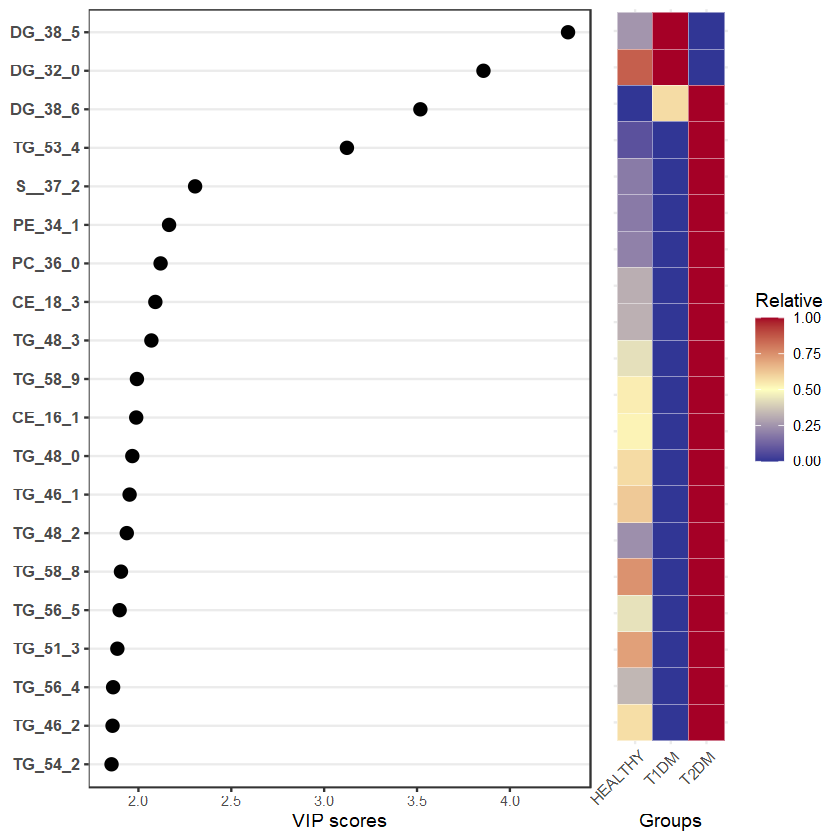

In [ ]:
# Assuming vip_df is now available, we proceed to visualization
# Create a combined cleveland plot with VIP scores and a heatmap of the top 20 lipids

# 1. Prepare the Top 20 Lipids
top_20 <- vip_df[1:40, ]
top_lipids <- top_20$Lipid

# 2. Prepare Heatmap Data (using your already Pareto-scaled pure_matrix)
# pure_matrix has samples as rows, lipids as columns
heatmap_df <- as.data.frame(pure_matrix) %>%
  select(all_of(top_lipids)) %>%
  mutate(Group = group_labels) %>%
  pivot_longer(cols = -Group, names_to = "Lipid", values_to = "Intensity") %>%
  group_by(Lipid, Group) %>%
  summarise(Mean_Intensity = mean(Intensity), .groups = 'drop')

# Normalize the means 0 to 1 for the color scale (matches the image style)
heatmap_df <- heatmap_df %>%
  group_by(Lipid) %>%
  mutate(Color_Scale = (Mean_Intensity - min(Mean_Intensity)) / (max(Mean_Intensity) - min(Mean_Intensity)))

# 3. Create Dot Plot (Left)
p1 <- ggplot(top_20, aes(x = VIP_Score, y = reorder(Lipid, VIP_Score))) +
  geom_point(size = 3, color = "black") +
  theme_bw() +
  labs(x = "VIP scores", y = NULL) +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text.y = element_text(size = 10, face = "bold"))

# 4. Create Heatmap (Right)
p2 <- ggplot(heatmap_df, aes(x = Group, y = reorder(Lipid, Mean_Intensity))) +
  geom_tile(aes(fill = Color_Scale), color = "white") +
  scale_fill_gradient2(low = "#313695", mid = "#ffffbf", high = "#a50026", midpoint = 0.5) +
  theme_minimal() +
  labs(x = "Groups", y = NULL, fill = "Relative") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1))

# 5. Combine and Display
grid.arrange(p1, p2, ncol = 2, widths = c(3, 1.2))

# Combine the plots into a single object first
combined_plot <- gridExtra::arrangeGrob(p1, p2, ncol = 2, widths = c(3, 1.2))

# Save using ggsave
ggsave(filename = "Lipid_VIP_Heatmap_v2.png", 
       plot = combined_plot, 
       path = work_dir,
       width = 10, 
       height = 8, 
       dpi = 300)

In [ ]:
# Lipids with VIP >1 are the top 65 lipids

top_65 <- vip_df[1:65, ]
top_lipids_65 <- top_65$Lipid

# 2. Update Heatmap Data
heatmap_df_65 <- as.data.frame(pure_matrix) %>%
  select(all_of(top_lipids_65)) %>%
  mutate(Group = group_labels) %>%
  pivot_longer(cols = -Group, names_to = "Lipid", values_to = "Intensity") %>%
  group_by(Lipid, Group) %>%
  summarise(Mean_Intensity = mean(Intensity), .groups = 'drop') %>%
  group_by(Lipid) %>%
  mutate(Color_Scale = (Mean_Intensity - min(Mean_Intensity)) / (max(Mean_Intensity) - min(Mean_Intensity)))

# 3. Re-create Plots with smaller text for 65 items
p1_65 <- ggplot(top_65, aes(x = VIP_Score, y = reorder(Lipid, VIP_Score))) +
  geom_point(size = 2, color = "black") +
  theme_bw() +
  labs(x = "VIP scores", y = NULL) +
  theme(panel.grid.major.y = element_line(linetype = "dotted", color = "grey80"),
        axis.text.y = element_text(size = 7)) # Smaller font for 65 items

p2_65 <- ggplot(heatmap_df_65, aes(x = Group, y = reorder(Lipid, Mean_Intensity))) +
  geom_tile(aes(fill = Color_Scale), color = "white") +
  scale_fill_gradient2(low = "#313695", mid = "#ffffbf", high = "#a50026", midpoint = 0.5) +
  theme_minimal() +
  labs(x = NULL, y = NULL, fill = "Rel.") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(angle = 90, vjust = 0.5, size = 8))

# 4. Save with a "Tall" Aspect Ratio
output_file_65 <- file.path(work_dir, "Lipid_VIP_Top65.png")

# Notice the height is increased to 18 inches to fit 65 rows comfortably
png(filename = output_file_65, 
    width = 8, 
    height = 18, 
    units = "in", 
    res = 300)

grid.arrange(p1_65, p2_65, ncol = 2, widths = c(3, 1))

dev.off()

message(paste("Top 65 plot saved to:", output_file_65))

agg_record_104592376 
                   2

Top 65 plot saved to: c:/Users/husse/VSCode_Projects/Lipidomics/Targeted_Lipidomics/MetaboAnalyst_Output/Lipid_VIP_Top65.png

